In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

Data Preprocessing & Exploration

In [3]:
try:
    df = pd.read_csv('/content/spam.csv', encoding='latin-1')
except:
    df = pd.read_csv('/content/spam.csv')

df = df.iloc[:, :2]
df.columns = ['label', 'text']

df['label'] = df['label'].map({'spam': 1, 'ham': 0})

def clean_text(text):
    text = text.lower() # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['text'] = df['text'].apply(clean_text)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Class Distribution:\n", df['label'].value_counts())

Class Distribution:
 label
0    4825
1     747
Name: count, dtype: int64


 Weak Learner Baseline

In [4]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_pred_train_stump = stump.predict(X_train)
y_pred_test_stump = stump.predict(X_test)

print("\n--- Weak Learner (Stump) Results ---")
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train_stump):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test_stump):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_stump))
print("Comment: Stumps are weak on text because they only look at a single feature (word) to classify.")


--- Weak Learner (Stump) Results ---
Train Accuracy: 0.8892
Test Accuracy: 0.8897
Confusion Matrix:
 [[965   0]
 [123  27]]
Comment: Stumps are weak on text because they only look at a single feature (word) to classify.


Manual AdaBoost (T = 15 rounds)


--- Manual AdaBoost Training ---
Iter 1: Error=0.1108, Alpha=1.0411, Misclassified Count=494
Iter 2: Error=0.4096, Alpha=0.1828, Misclassified Count=508
Iter 3: Error=0.4236, Alpha=0.1540, Misclassified Count=3860
Iter 4: Error=0.4172, Alpha=0.1672, Misclassified Count=507
Iter 5: Error=0.4289, Alpha=0.1431, Misclassified Count=3860
Iter 6: Error=0.4300, Alpha=0.1409, Misclassified Count=523
Iter 7: Error=0.4391, Alpha=0.1224, Misclassified Count=3860
Iter 8: Error=0.4384, Alpha=0.1238, Misclassified Count=507
Iter 9: Error=0.4452, Alpha=0.1101, Misclassified Count=3860
Iter 10: Error=0.4371, Alpha=0.1264, Misclassified Count=556
Iter 11: Error=0.4452, Alpha=0.1100, Misclassified Count=3860
Iter 12: Error=0.4361, Alpha=0.1285, Misclassified Count=508
Iter 13: Error=0.4456, Alpha=0.1093, Misclassified Count=3860
Iter 14: Error=0.4476, Alpha=0.1052, Misclassified Count=531
Iter 15: Error=0.4526, Alpha=0.0951, Misclassified Count=3860


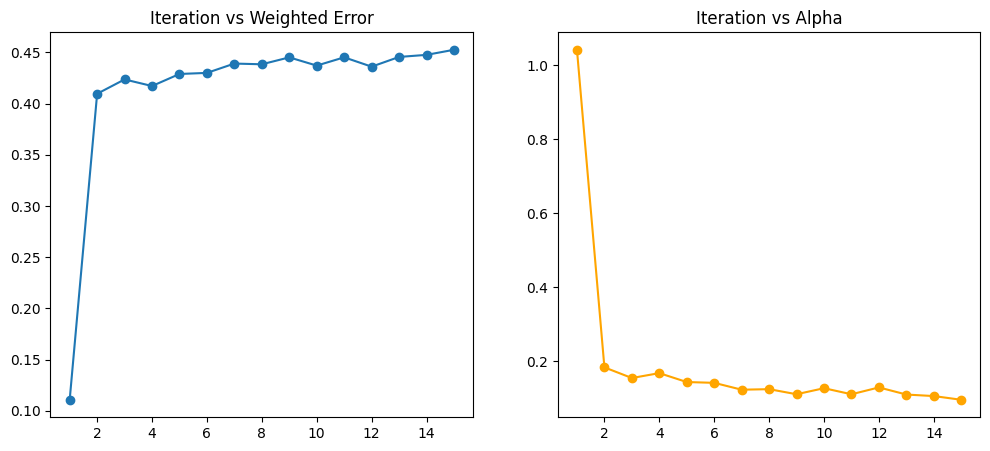


--- Manual AdaBoost Results ---
Train Accuracy: 0.8907
Test Accuracy: 0.8906
Confusion Matrix:
 [[965   0]
 [122  28]]


In [5]:
n_samples = X_train.shape[0]
w = np.full(n_samples, 1 / n_samples)
alphas = []
models = []
errors_history = []

T = 15
print("\n--- Manual AdaBoost Training ---")

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X_train, y_train, sample_weight=w)
    models.append(stump)

    predictions = stump.predict(X_train)

    misclassified = (predictions != y_train)
    error = np.sum(w[misclassified])

    epsilon = 1e-10
    alpha = 0.5 * np.log((1 - error + epsilon) / (error + epsilon))
    alphas.append(alpha)
    errors_history.append(error)

    misclassified_indices = np.where(misclassified)[0]
    print(f"Iter {t+1}: Error={error:.4f}, Alpha={alpha:.4f}, Misclassified Count={len(misclassified_indices)}")

    w = w * np.exp(np.where(misclassified, alpha, -alpha))
    w /= np.sum(w)

def manual_predict(X_input):
    final_pred = np.zeros(X_input.shape[0])
    for alpha, model in zip(alphas, models):
        pred = np.where(model.predict(X_input) == 0, -1, 1)
        final_pred += alpha * pred
    return np.where(np.sign(final_pred) == -1, 0, 1)

y_manual_pred_test = manual_predict(X_test)
y_manual_pred_train = manual_predict(X_train)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, T+1), errors_history, marker='o')
plt.title("Iteration vs Weighted Error")
plt.subplot(1, 2, 2)
plt.plot(range(1, T+1), alphas, marker='o', color='orange')
plt.title("Iteration vs Alpha")
plt.show()

print("\n--- Manual AdaBoost Results ---")
print(f"Train Accuracy: {accuracy_score(y_train, y_manual_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_manual_pred_test):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_manual_pred_test))

Sklearn AdaBoost

In [6]:
ada_sklearn = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42
)
ada_sklearn.fit(X_train, y_train)
y_pred_sklearn = ada_sklearn.predict(X_test)

print("\n--- Sklearn AdaBoost Results ---")
print(f"Train Accuracy: {ada_sklearn.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_sklearn):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_sklearn))


--- Sklearn AdaBoost Results ---
Train Accuracy: 0.9031
Test Accuracy: 0.8996
Confusion Matrix:
 [[965   0]
 [112  38]]


--- Baseline Stump Report ---
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        49
           1       0.69      0.59      0.63        41

    accuracy                           0.69        90
   macro avg       0.69      0.68      0.68        90
weighted avg       0.69      0.69      0.69        90



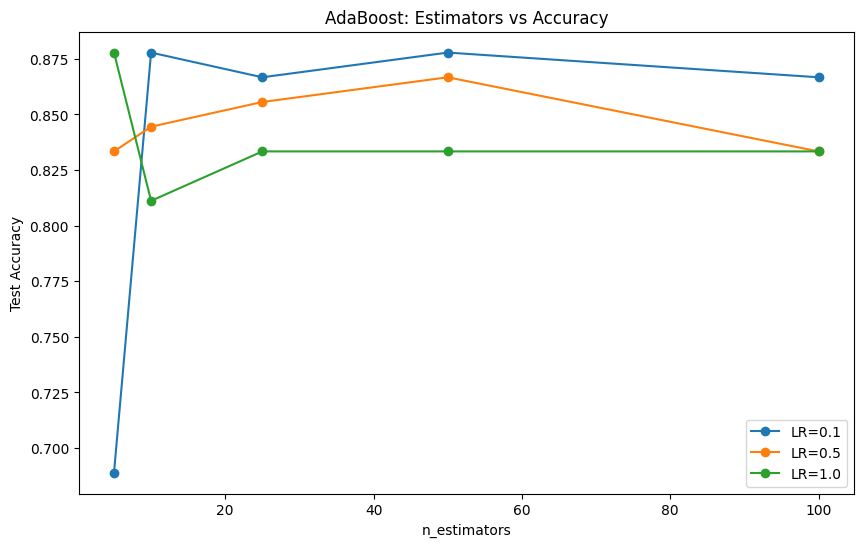

Best Config: {'n_estimators': 10, 'learning_rate': 0.1} with Accuracy: 0.8778


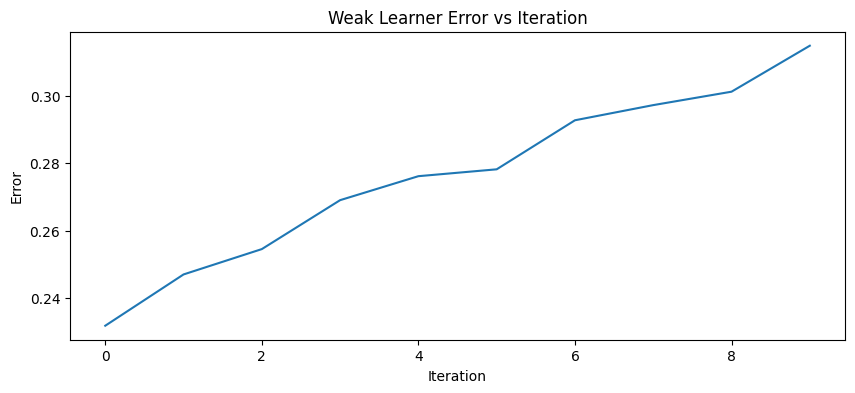

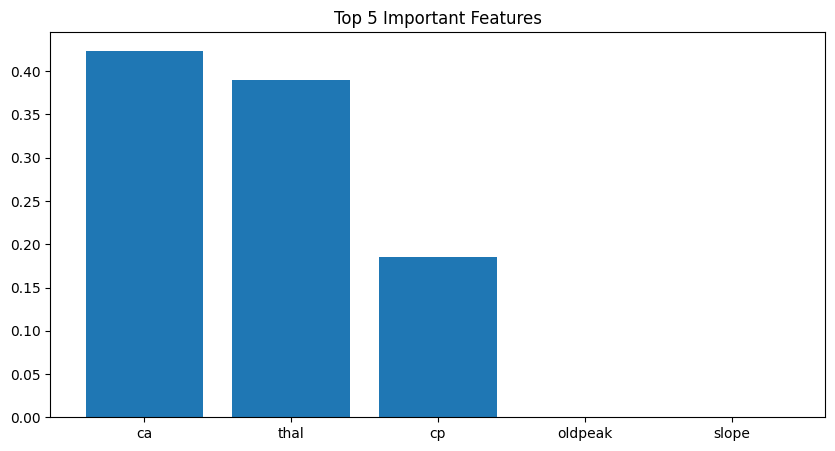

Top 5 Features: ['ca', 'thal', 'cp', 'oldpeak', 'slope']
Interpretation: Features like 'cp' (chest pain) and 'thalach' (max heart rate) are medically critical indicators of cardiac stress.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
try:

    df = pd.read_csv(url, names=names, na_values='?')
    df = df.dropna()
except:
    print("Could not load from URL. Please ensure local CSV is available.")

    df = pd.DataFrame(np.random.rand(100, 14), columns=names)
    df['target'] = np.random.randint(0, 2, 100)

X = df.drop('target', axis=1)
y = (df['target'] > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
print("--- Baseline Stump Report ---")
print(classification_report(y_test, stump.predict(X_test)))


n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

best_score = 0
best_params = {}
results = {}

for lr in learning_rates:
    accuracies = []
    for n_est in n_estimators_list:
        ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                 n_estimators=n_est, learning_rate=lr, random_state=42)
        ada.fit(X_train, y_train)
        acc = accuracy_score(y_test, ada.predict(X_test))
        accuracies.append(acc)

        if acc > best_score:
            best_score = acc
            best_params = {'n_estimators': n_est, 'learning_rate': lr}
            best_model = ada

    results[lr] = accuracies

# Plot: n_estimators vs accuracy
plt.figure(figsize=(10, 6))
for lr, accs in results.items():
    plt.plot(n_estimators_list, accs, marker='o', label=f'LR={lr}')
plt.xlabel("n_estimators")
plt.ylabel("Test Accuracy")
plt.legend()
plt.title("AdaBoost: Estimators vs Accuracy")
plt.show()

print(f"Best Config: {best_params} with Accuracy: {best_score:.4f}")

# --- Part C: Misclassification Pattern ---

# Extracting errors from the best model
errors = []
for real_err in best_model.estimator_errors_:
    errors.append(real_err)

plt.figure(figsize=(10, 4))
plt.plot(errors)
plt.title("Weak Learner Error vs Iteration") # [cite: 82]
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

# --- Part D: Visual Explainability ---
# Feature Importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_5_features = [X.columns[i] for i in indices[:5]]

plt.figure(figsize=(10, 5))
plt.bar(range(5), importances[indices[:5]])
plt.xticks(range(5), top_5_features)
plt.title("Top 5 Important Features")
plt.show()

print(f"Top 5 Features: {top_5_features}")
print("Interpretation: Features like 'cp' (chest pain) and 'thalach' (max heart rate) are medically critical indicators of cardiac stress.") # [cite: 90]

WISDM file not found. Generating dummy data.

--- WISDM Baseline Results ---
Accuracy: 0.6733
Confusion Matrix:
 [[202   0]
 [ 98   0]]

--- Manual AdaBoost (WISDM) ---
Iter 1: Error=0.3400, Alpha=0.3316
Iter 6: Error=0.4638, Alpha=0.0726
Iter 11: Error=0.4956, Alpha=0.0088
Iter 16: Error=0.4958, Alpha=0.0084


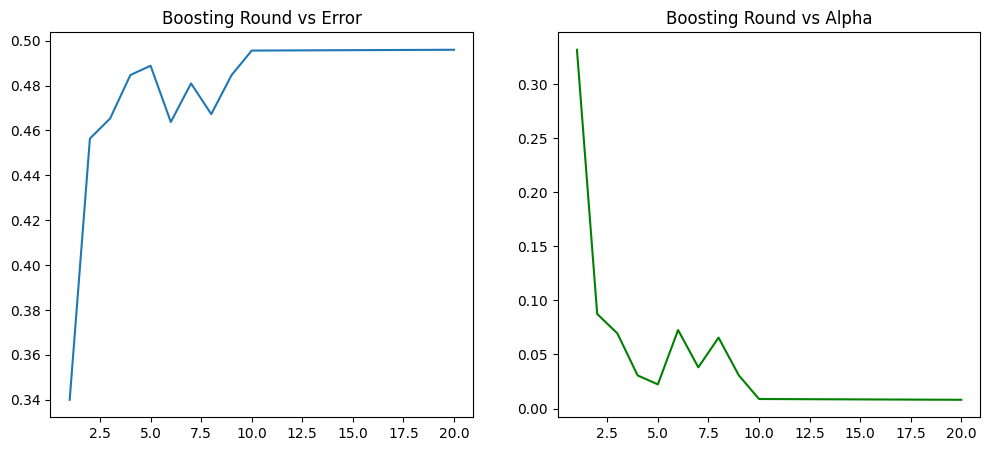

Manual AdaBoost Test Accuracy: 0.6733
Confusion Matrix:
 [[202   0]
 [ 98   0]]

--- Sklearn AdaBoost Results (WISDM) ---
Test Accuracy: 0.6733
Confusion Matrix:
 [[202   0]
 [ 98   0]]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# --- Part A: Data Preparation ---

columns = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']
try:

    df = pd.read_csv('WISDM_ar_v1.1_raw.txt', header=None, names=columns, on_bad_lines='skip')
except:
    # Fallback dummy data generation if file missing
    print("WISDM file not found. Generating dummy data.")
    df = pd.DataFrame(np.random.rand(1000, 6), columns=columns)
    activities = ['Walking', 'Jogging', 'Upstairs', 'Sitting', 'Standing', 'Downstairs']
    df['activity'] = np.random.choice(activities, 1000)

# Cleaning: Remove semicolon from Z-axis if present and convert to float
df['z'] = df['z'].astype(str).str.replace(';', '').astype(float)

# Create Binary Labels
vigorous = ['Jogging', 'Upstairs']
df['label'] = df['activity'].apply(lambda x: 1 if x in vigorous else 0)

# Select features
X = df[['x', 'y', 'z']].values
y = df['label'].values

# Split 70/30 [cite: 109]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Part B: Weak Classifier Baseline ---
# Decision Stump
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
y_pred_stump = stump.predict(X_test)

print("\n--- WISDM Baseline Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_stump):.4f}") # [cite: 114]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stump)) # [cite: 115]

# --- Part C: Manual AdaBoost  ---

n_samples = X_train.shape[0]
w = np.full(n_samples, 1 / n_samples)
alphas = []
models = []
error_history = []

T = 20
print("\n--- Manual AdaBoost (WISDM) ---")

for t in range(T):
    # Train weak learner
    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X_train, y_train, sample_weight=w)
    models.append(stump)

    predictions = stump.predict(X_train)
    misclassified = (predictions != y_train)

    # Calculate error and alpha
    error = np.sum(w[misclassified])
    epsilon = 1e-10
    alpha = 0.5 * np.log((1 - error + epsilon) / (error + epsilon))
    alphas.append(alpha)
    error_history.append(error)

    # Report Iteration Stats
    if t % 5 == 0: # Printing every 5th to save space, remove condition to print all
        print(f"Iter {t+1}: Error={error:.4f}, Alpha={alpha:.4f}")

    # Update & Normalize Weights
    w = w * np.exp(np.where(misclassified, alpha, -alpha))
    w /= np.sum(w)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, T+1), error_history)
plt.title("Boosting Round vs Error")
plt.subplot(1, 2, 2)
plt.plot(range(1, T+1), alphas, color='green')
plt.title("Boosting Round vs Alpha")
plt.show()

# Manual Prediction Logic
final_pred_test = np.zeros(X_test.shape[0])
for alpha, model in zip(alphas, models):
    pred = np.where(model.predict(X_test) == 0, -1, 1)
    final_pred_test += alpha * pred
y_manual_final = np.where(np.sign(final_pred_test) == -1, 0, 1)

print(f"Manual AdaBoost Test Accuracy: {accuracy_score(y_test, y_manual_final):.4f}") # [cite: 129]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_manual_final)) # [cite: 130]

# --- Part D: Sklearn AdaBoost ---

ada_wisdm = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)
ada_wisdm.fit(X_train, y_train)

print("\n--- Sklearn AdaBoost Results (WISDM) ---")
print(f"Test Accuracy: {accuracy_score(y_test, ada_wisdm.predict(X_test)):.4f}") # [cite: 140]
print("Confusion Matrix:\n", confusion_matrix(y_test, ada_wisdm.predict(X_test))) # [cite: 141]